In [1]:
import os
import sys
import torch
import time
import shutil
from torchvision.transforms import ToPILImage
from os.path import join

base_directory = "../"
sys.path.insert(0, base_directory)

output_base_dir = join(base_directory, "./output/sd2-notebook/")
output_directory = join(output_base_dir, "autoencoder/")

try:
    shutil.rmtree(output_directory)
except Exception as e:
    print(e, "\n", "Creating the path...")
    os.makedirs(output_directory, exist_ok=True)
else:
    os.makedirs(output_directory, exist_ok=True)

from stable_diffusion.stable_diffusion import StableDiffusion
from stable_diffusion.utils.model import *
from stable_diffusion.utils.utils import SectionManager as section
from stable_diffusion.utils.utils import *
from stable_diffusion.constants import ModelsPathTree


to_pil = lambda image: ToPILImage()(torch.clamp((image + 1.0) / 2.0, min=0.0, max=1.0))
device = get_device()

INFO: Using CUDA device: NVIDIA GeForce RTX 3080 Ti


In [2]:
pt = ModelsPathTree(base_directory=base_directory)
print(pt.decoder)  # should be `.../kcg-ml-sd1p4/input/model/autoencoder/encoder.ckpt`

{'decoder_path': 'c:\\Users\\igor-\\.cloned\\kcg-ml-sd1p4\\input\\model\\autoencoder\\decoder.ckpt'}


In [3]:
# initialize an empty stable diffusion class
stable_diffusion = StableDiffusion(device=device)
get_memory_status()

INFO: Device given. Using device cuda:0`device` is None. Falling back to current device: cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 11086 MiB
Used: 1201 MiB


In [4]:
# initialize an empty latent diffusion model; it returns self.model
stable_diffusion.quick_initialize()
get_memory_status()

INFO: Device given. Using device cuda:0`device` is None. Falling back to current device: cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 10630 MiB
Used: 1657 MiB


In [5]:
# the latent diffusion class has a method to load the autoencoder, since it is a submodel of it. it returns the autoencoder
stable_diffusion.model.load_autoencoder(**pt.autoencoder)
get_memory_status()

Autoencoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\autoencoder.ckpt
Total: 12287 MiB
Free: 10630 MiB
Used: 1657 MiB


In [6]:
# the autoencoder has a method to load the encoder, since it's one of its submodels. it returns the encoder
stable_diffusion.model.autoencoder.load_encoder(**pt.encoder)
get_memory_status()

Encoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\encoder.ckpt
Total: 12287 MiB
Free: 10484 MiB
Used: 1803 MiB


In [7]:
# since each method returns the thing it loads, we could, for convenience, one-line that out: intialize a latent diffusion model, then load the autoencoder, then load the encoder
stable_diffusion.quick_initialize().load_autoencoder(**pt.autoencoder).load_encoder(
    **pt.encoder
)
get_memory_status()

INFO: Device given. Using device cuda:0`device` is None. Falling back to current device: cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Autoencoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\autoencoder.ckpt
Encoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\encoder.ckpt
Total: 12287 MiB
Free: 10484 MiB
Used: 1803 MiB


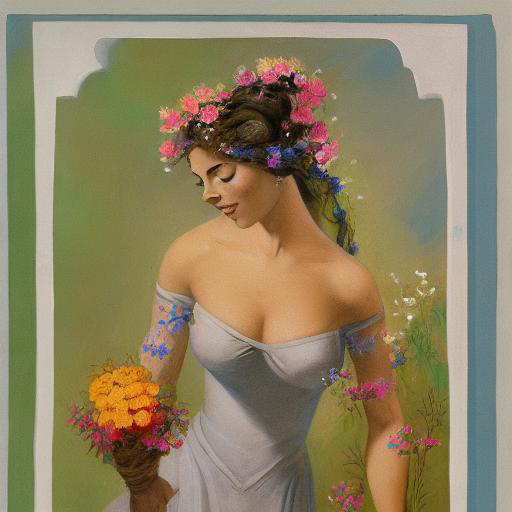

In [8]:
# load an image to test the encoder module
img = load_img(join(base_directory, "./input/test_img.jpg")).to(device)
to_pil(img.squeeze(0))

In [9]:
# get the latent representation of the test image
encoded_img = stable_diffusion.encode(img)
get_memory_status()

Total: 12287 MiB
Free: 9136 MiB
Used: 3151 MiB


In [10]:
# check its shape
encoded_img.shape

torch.Size([1, 4, 64, 64])

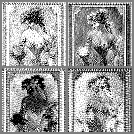

In [11]:
# show each dimension of the latent representation
grid = torchvision.utils.make_grid(
    encoded_img.permute(1, 0, 2, 3),
    nrow=2,
    normalize=False,
    range=(-1, 1),
    scale_each=True,
    pad_value=0,
)
dim_grid_image = to_pil(grid)
dim_grid_image.save(join(output_directory, f"encoding_dimensions_grid.png"))
dim_grid_image

In [12]:
# save it as a tensor
torch.save(encoded_img, join(output_base_dir, f"encoded_img_tensor.pt"))

In [13]:
del encoded_img
torch.cuda.empty_cache()
print(get_memory_status())

Total: 12287 MiB
Free: 9742 MiB
Used: 2545 MiB
None


In [14]:
# load it back
encoded_img = torch.load(join(output_base_dir, f"encoded_img_tensor.pt"))
torch.cuda.empty_cache()
get_memory_status()

Total: 12287 MiB
Free: 9740 MiB
Used: 2547 MiB


In [15]:
encoded_img.shape

torch.Size([1, 4, 64, 64])

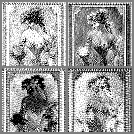

In [16]:
grid = torchvision.utils.make_grid(
    encoded_img.permute(1, 0, 2, 3),
    nrow=2,
    normalize=False,
    range=(-1, 1),
    scale_each=True,
    pad_value=0,
)
to_pil(grid)

In [17]:
del grid
torch.cuda.empty_cache()
get_memory_status()

Total: 12287 MiB
Free: 9740 MiB
Used: 2547 MiB


In [18]:
# unload the encoder submodel
stable_diffusion.model.autoencoder.unload_encoder()
torch.cuda.empty_cache()
get_memory_status()

Total: 12287 MiB
Free: 9866 MiB
Used: 2421 MiB


In [19]:
# load the decoder submodel
stable_diffusion.model.autoencoder.load_decoder(**pt.decoder)
torch.cuda.empty_cache()
get_memory_status()

Decoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\decoder.ckpt
Total: 12287 MiB
Free: 9800 MiB
Used: 2487 MiB


Total: 12287 MiB
Free: 9800 MiB
Used: 2487 MiB


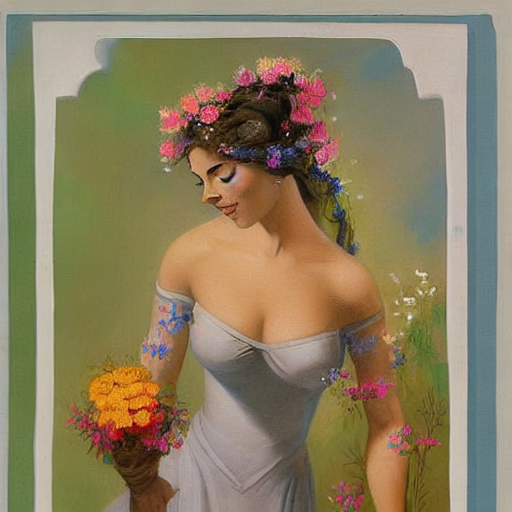

In [20]:
# decode the latent representation that we loaded from disk
decoded_img = stable_diffusion.decode(encoded_img)
save_images(decoded_img, join(output_directory, f"decoded_img.png"))
torch.cuda.empty_cache()
get_memory_status()
to_pil(decoded_img[0])

In [21]:
# initially loaded image isn't the same as the decoded image
torch.norm(img - decoded_img)

tensor(51.6279, device='cuda:0')

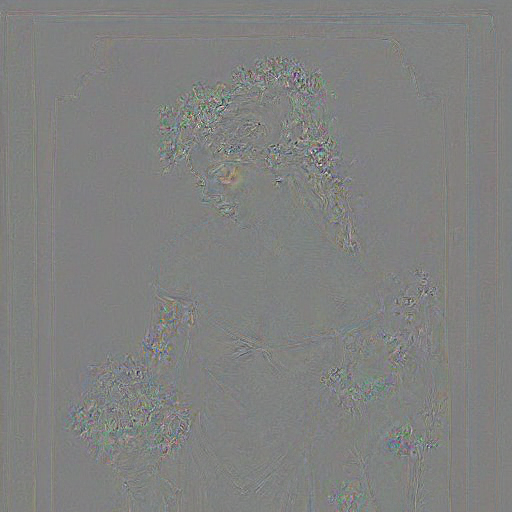

In [22]:
# plot the difference as an image
diff_img = to_pil((img - decoded_img).squeeze(0))
diff_img.save(join(output_directory, f"diff_img.png"))
diff_img